<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Baseball-Run-Values-from-Regression" data-toc-modified-id="Baseball-Run-Values-from-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Baseball Run Values from Regression</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Our-first-regression-model" data-toc-modified-id="Our-first-regression-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Our first regression model</a></span></li><li><span><a href="#Are-Ks-more-costly-than-other-outs?" data-toc-modified-id="Are-Ks-more-costly-than-other-outs?-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Are Ks more costly than other outs?</a></span></li><li><span><a href="#What-happens-if-we-only-use-a-year-of-data?" data-toc-modified-id="What-happens-if-we-only-use-a-year-of-data?-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>What happens if we only use a year of data?</a></span></li></ul></li><li><span><a href="#Four-Factor-Model" data-toc-modified-id="Four-Factor-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Four Factor Model</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Four-Factors-and-Winning-Pct" data-toc-modified-id="Four-Factors-and-Winning-Pct-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Four Factors and Winning Pct</a></span></li><li><span><a href="#Four-Factors-and-the-log-Rating-Ratio" data-toc-modified-id="Four-Factors-and-the-log-Rating-Ratio-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Four Factors and the log Rating Ratio</a></span></li><li><span><a href="#By-Games" data-toc-modified-id="By-Games-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>By Games</a></span></li></ul></li><li><span><a href="#Real-Plus/Minus" data-toc-modified-id="Real-Plus/Minus-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Real Plus/Minus</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

from regression_helper import multiple_regression

## Baseball Run Values from Regression

### Load Data

In [2]:
# Load lahman_teams.csv obtained from the lahman_main databank. 
# This table is a slight modification of the regular table.
lahman = pd.read_csv("lahman_teams.csv")

# Restrict to after the year 2000
lahman_2000s = lahman.loc[lahman['yearID'] >= 2000]
lahman_2000s.head()

,yearID,franchID,RAA,O,O_nonK,SO,X1B,X2B,X3B,HR,BB,HBP,SB,CS
982,2000,ANA,181.600705,4054,3030.0,1024.0,995,309,34,236,608,47.0,93.0,52.0
983,2000,ARI,109.600705,4061,3086.0,975.0,961,282,44,179,535,59.0,97.0,44.0
984,2000,ATL,127.600705,3999,2989.0,1010.0,1011,274,26,179,595,59.0,148.0,56.0
985,2000,BAL,111.600705,4041,3141.0,900.0,992,310,22,184,558,49.0,126.0,65.0
986,2000,BOS,109.600705,4127,3108.0,1019.0,988,316,32,167,611,42.0,43.0,30.0


### Our first regression model

In [3]:
dep_vars = 'RAA'
ind_vars = ['O', 'X1B', 'X2B', 'X3B', 'HR', 'BB', 'HBP', 'SB', 'CS']
coefs, predictions, errors = multiple_regression(dep_vars, ind_vars, lahman_2000s)
coefs

O     -0.259851
X1B    0.479376
X2B    0.744706
X3B    1.078258
HR     1.436029
BB     0.288419
HBP    0.335237
SB     0.182543
CS    -0.372263
dtype: float64

### Are Ks more costly than other outs?

In [4]:
ind_vars_with_K = ['O_nonK', 'SO', 'X1B', 'X2B', 'X3B', 'HR', 'BB', 'HBP', 'SB', 'CS']
coefs_with_K, _, _ = multiple_regression(dep_vars, ind_vars_with_K, lahman_2000s)
coefs_with_K

O_nonK   -0.248914
SO       -0.268120
X1B       0.457801
X2B       0.733130
X3B       1.095368
HR        1.438783
BB        0.288666
HBP       0.335617
SB        0.187726
CS       -0.391668
dtype: float64

### What happens if we only use a year of data?

In [5]:
lahman_2016 = lahman.loc[lahman['yearID'] == 2016]
coefs_2016, _, _ = multiple_regression(dep_vars, ind_vars, lahman_2016)
coefs_2016

O     -0.251029
X1B    0.388503
X2B    1.132619
X3B    0.816812
HR     1.316626
BB     0.187916
HBP    0.533701
SB     0.135256
CS     0.014569
dtype: float64

## Four Factor Model

### Load Data

In [6]:
nba_teams_full = pd.read_csv('team_season_ff_data.csv')
nba_teams = nba_teams_full.loc[nba_teams_full.season >= 2000]
nba_teams.head()

,team,season,win_pct,rtg_rat,log_rtg_rat,eFG,Tov,Reb,Ftr
516,ORL,2000,0.524390,1.010774,0.010716,0.380505,-1.299623,-0.374888,-2.114058
517,OKC,2000,0.536585,1.000000,0.000000,0.083395,0.241673,-0.335741,0.544216
518,UTA,2000,0.646341,1.050781,0.049534,0.876757,-0.388508,1.107366,-0.801943
519,CHI,2000,0.182927,0.905871,-0.098858,-1.824042,0.602356,-1.022925,-0.950757
520,CLE,2000,0.365854,0.956149,-0.044842,-0.652338,0.958817,0.290324,-0.252797


### Four Factors and Winning Pct

In [7]:
dep_vars = 'win_pct'
ind_vars = ['eFG', 'Tov', 'Reb', 'Ftr']
coefs, _, _ = multiple_regression(dep_vars, ind_vars, nba_teams)
coefs = coefs / coefs.abs().sum()
coefs

eFG    0.469091
Tov   -0.231724
Reb    0.160684
Ftr    0.138501
dtype: float64

### Four Factors and the log Rating Ratio

In [8]:
dep_vars = 'log_rtg_rat'
coefs, _, _ = multiple_regression(dep_vars, ind_vars, nba_teams)
coefs = coefs / coefs.abs().sum()
coefs

eFG    0.476750
Tov   -0.229748
Reb    0.161694
Ftr    0.131809
dtype: float64

### By Games

In [9]:
games = pd.read_csv('game_ff_data_2016.csv')
games.head()

,GAME_ID,TEAM_NAME,OPP_TEAM_NAME,log_rtg_rat,eFG,Tov,Reb,Ftr
0,21600001,Knicks,Cavaliers,-0.231130,-1.392594,0.751141,-0.344226,0.335651
1,21600002,Jazz,Trail Blazers,-0.128505,-0.760523,0.071183,-0.015786,-0.676140
2,21600003,Spurs,Warriors,0.239358,0.318357,-0.448785,2.341258,0.536404
3,21600004,Magic,Heat,-0.091060,-0.967581,-0.148804,-0.576067,1.315323
4,21600005,Pacers,Mavericks,0.079820,0.438232,0.191175,-0.199326,1.660617


In [10]:
dep_vars = 'log_rtg_rat'
coefs, _, _ = multiple_regression(dep_vars, ind_vars, games)
coefs = coefs / coefs.abs().sum()
coefs

eFG    0.496854
Tov   -0.220977
Reb    0.191796
Ftr    0.090373
dtype: float64

## Real Plus/Minus

In [11]:
from regression_helper import multiple_regression_big

df = pd.read_csv('nba_stints_2015_full.csv.gz')
df.head()

,away_ortg,away_poss,away_pts,away_unit,home_ortg,home_poss,home_pts,home_unit,net_poss,home_netpts,home_netrtg
0,100.0,4,4,"['Stephen Curry', 'Klay Thompson', 'Andre Iguo...",275.0,4,11,"['Ronnie Price', 'Wayne Ellington', 'Wesley Jo...",8,7,87.5
1,NaN,0,0,"['Ray McCallum', 'Ben McLemore', 'Nik Stauskas...",0.0,1,0,"['Jarrett Jack', 'Alan Anderson', 'Joe Johnson...",1,0,0.0
2,170.0,10,17,"['Stephen Curry', 'Klay Thompson', 'Harrison B...",90.0,10,9,"['Ronnie Price', 'Wayne Ellington', 'Wesley Jo...",20,-8,-40.0
3,0.0,2,0,"['Stephen Curry', 'Klay Thompson', 'Harrison B...",200.0,3,6,"['Ronnie Price', 'Wayne Ellington', 'Wesley Jo...",5,6,120.0
4,100.0,1,1,"['Stephen Curry', 'Klay Thompson', 'Harrison B...",NaN,0,2,"['Ronnie Price', 'Wayne Ellington', 'Wesley Jo...",1,1,100.0


In [12]:
stints = pd.read_csv('nba_stints_2015_binary.csv.gz')
stints.head()

,net_rtg,net_poss,HCA,A.J. Price,Aaron Brooks,Aaron Gordon,Adreian Payne,Al Horford,Al Jefferson,Al-Farouq Aminu,...,Will Barton,Will Bynum,Will Cherry,Willie Green,Wilson Chandler,Xavier Henry,Zach LaVine,Zach Randolph,Zaza Pachulia,Zoran Dragic
0,87.5,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-40.0,20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,120.0,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
players = list(stints.columns[3:])
ind_vars = list(stints.columns[2:])
apm = multiple_regression_big('net_rtg', ind_vars, stints, weights='net_poss')
apm

A.J. Price           -7.991129
Aaron Brooks         -1.756187
Aaron Gordon         -7.374247
Adreian Payne       -10.779553
Al Horford            0.181153
Al Jefferson         -7.940346
Al-Farouq Aminu      -2.012078
Alan Anderson        -1.572974
Alec Burks           -7.140850
Alex Kirk           -24.311230
Alex Len             -6.813328
Alexey Shved         -3.265149
Alexis Ajinca        -2.086245
Allen Crabbe         -6.689232
Alonzo Gee           -8.013036
Amar'e Stoudemire    -6.188813
Amir Johnson         -1.675636
Anderson Varejao     -8.752846
Andre Dawkins       -11.013330
Andre Drummond       -2.428676
Andre Iguodala       -5.328919
Andre Miller         -2.296580
Andre Roberson       -3.216422
Andrea Bargnani     -11.691085
Andrei Kirilenko    -22.361349
Andrew Bogut         -4.751047
Andrew Nicholson     -7.852213
Andrew Wiggins       -4.104541
Anthony Bennett     -11.320015
Anthony Davis         2.354493
                       ...    
Trevor Booker        -4.892970
Trey Bur

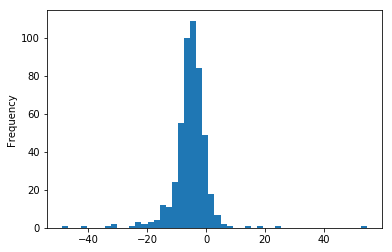

In [14]:
apm.plot.hist(bins=50)

In [15]:
apm_HCA = apm['HCA']
print("Home Court Advantage for Net Rating: {:.2f}".format(apm_HCA))
print()
print("Top 20 by APM\n" + 40*"=")
print(apm[players].sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by APM\n" + 40*"=")
print(apm[players].sort_values(ascending=True)[:20].to_string())

Home Court Advantage for Net Rating: 1.16

Top 20 by APM
Jerrelle Benimon    54.572027
Malcolm Lee         23.899380
Eric Moreland       19.364534
Sim Bhullar         13.482017
David Stockton       8.342210
Lucas Nogueira       6.073172
Toure' Murry         5.806591
Sean Kilpatrick      4.815747
Paul Millsap         4.618496
Quincy Miller        4.075336
Cory Jefferson       3.922756
Russ Smith           3.896168
Stephen Curry        3.804560
Xavier Henry         3.728450
James Harden         2.499012
Anthony Davis        2.354493
Derrick Rose         2.079204
C.J. Wilcox          2.069485
Pero Antic           2.056680
Carmelo Anthony      1.989486

Bottom 20 by APM
Julius Randle         -48.888431
Bruno Caboclo         -41.208826
David Wear            -33.999005
Mike Malone           -31.686993
Kalin Lucas           -30.696550
Alex Kirk             -24.311230
Patrick Christopher   -23.057703
Glen Rice Jr.         -22.760322
Andrei Kirilenko      -22.361349
Dahntay Jones         -21.46

In [16]:
from regression_helper import multiple_regression_big_with_penalty

rapm = multiple_regression_big_with_penalty('net_rtg', ind_vars, stints, weights='net_poss', penalty=1000.)
rapm

A.J. Price          -2.208826
Aaron Brooks         1.373228
Aaron Gordon        -1.665784
Adreian Payne       -3.259032
Al Horford           0.756031
Al Jefferson        -0.794095
Al-Farouq Aminu      2.115859
Alan Anderson        2.050260
Alec Burks          -1.633426
Alex Kirk           -0.990632
Alex Len            -0.775889
Alexey Shved         0.140503
Alexis Ajinca        1.286386
Allen Crabbe        -1.474395
Alonzo Gee          -1.868703
Amar'e Stoudemire   -0.245777
Amir Johnson         1.351582
Anderson Varejao    -1.919260
Andre Dawkins       -0.370579
Andre Drummond       1.222294
Andre Iguodala       0.695213
Andre Miller         0.529875
Andre Roberson       1.858097
Andrea Bargnani     -3.915587
Andrei Kirilenko    -2.172905
Andrew Bogut         0.654862
Andrew Nicholson    -1.698947
Andrew Wiggins       0.031883
Anthony Bennett     -4.188602
Anthony Davis        5.512299
                       ...   
Trevor Booker       -0.242707
Trey Burke          -0.577024
Tristan Th

Home Court Advantage for Net Rating: 1.17

Top 20 by RAPM
Stephen Curry        5.987077
Anthony Davis        5.512299
Kyle Korver          5.426923
James Harden         5.290294
Khris Middleton      5.036466
Draymond Green       4.909569
LeBron James         4.895868
Kawhi Leonard        4.727226
Cory Jefferson       4.683430
Chris Paul           4.526599
Kelly Olynyk         4.360387
Zach Randolph        4.324951
Luol Deng            4.048028
Derrick Rose         4.036020
DeMarcus Cousins     3.993643
Carmelo Anthony      3.956649
LaMarcus Aldridge    3.891045
George Hill          3.876510
Gordon Hayward       3.843642
Ricky Rubio          3.765408

Bottom 20 by RAPM
Brandon Rush        -7.205629
Johnny O'Bryant     -5.463691
Landry Fields       -5.299056
Perry Jones         -4.819680
Samuel Dalembert    -4.626875
Martell Webster     -4.611679
Archie Goodwin      -4.515100
Joffrey Lauvergne   -4.418567
Malcolm Thomas      -4.405789
Dahntay Jones       -4.308704
Chris Kaman         -4.

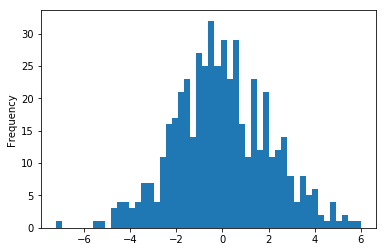

In [18]:
rapm.plot.hist(bins=50)

rapm_HCA = rapm['HCA']
print("Home Court Advantage for Net Rating: {:.2f}".format(rapm_HCA))
print()
print("Top 20 by RAPM\n" + 40*"=")
print(rapm[players].sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by RAPM\n" + 40*"=")
print(rapm[players].sort_values(ascending=True)[:20].to_string())